# Glaucoma Diagnosis and Segmentation
## Introduction :
During this challenge, we tried to diagnose glaucoma from images of the inside back surface of the eye. We have developed a deep learning system that can detect glaucoma disease. We have worked with multiple convolutional neural networks models UNet, VGG, and AlexNet and tested different kinds of data augmentation.

## Plan :
   >  __1. Data Pre-processing__
   
   >  __2. VGG and AlexNet Networks__
   
   >  __3. Training and Testing__ 
   
   >  __4. Conclusion__ 


In [1]:
import os
import json
import csv
import random
import pickle
import cv2
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage.measurements import label
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

#dimension of the images:2124x2056

## README
this notebook presents two models: VGG and AlexNet. It is implemented so that the AlexNet can be runned. If you want to test with the VGG here are the parameters to change:

change ___output_size = (224,224)___
for the best model we found put __lr = 1e-4__, __batch_size = 4__, __num_workers = 8__
Then you can uncomment all the code related to VGG (and comment the AlexNet code) in the following parts:

- Train The VGG Model (you'll see. a variable set to true in the training function that adapats the training for VGG)

- Confusion Matrix on training set

- Load Models Weights

- Predictions on test set

Other paramters that didn't work but available if you want to try:

- Confusion Matrix on training set

- Load Models Weights

- Predictions on test set

Other paramters that didn't work but available if you want to try:

we implemented the clahe functions for __lightning Normalization and brightness__. As it didn't improved our model we didn't use it but if you want to activate it please put the variable normalize_light_using_CLAHE = True

in the section ___"UPSAMPLING of the training set With Rotation Functions"___ we impemented a data augmentation that adds rotated images from our dataset. it didn't improve our results. if you want to uncomment the code and add samples through the variable added_values for each lable.

# 1. Data Pre-processing


In [2]:
# For Alex Net the ouput size is (256,256)
# For the VGG net the output size is (224,224)

output_size = (256,256)

### CLAHE FUNCTION - LIGHTNING CONTRAST NORMALIZATION 
The different lighting conditions and intensity variations among images across various databases were circumvented by performing normalization of the histogram using Contrast Limited Adaptive HistogramEqualization (CLAHE). 
For this, we have implemented a function that allows to improve the contrast of images, it takes as input an image, and generates an image with a better contrast. Instead of using Adaptive histogram equalization (AHE) which over amplifies noise in relatively homogeneous regions of an image, we have used a variant of adaptive histogram equalization called contrast limited adaptive histogram equalization (CLAHE) prevents this by limiting the amplification.


In [3]:
# CLAHE Functions are designed for lightning Normalization and brightness  

def clahe_single(ori_img,clipLimit,tileGridSize):

    img = np.array(Image.open(ori_img).convert('RGB'))
    
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit,tileGridSize)
    lab_planes[0] = clahe.apply(lab_planes[0])
    
    lab = cv2.merge(lab_planes)
    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    return rgb
    
def clahe_all1(ori_img):
    rgb = clahe_single(ori_img, 0.1 , (8,8))
    return Image.fromarray(rgb)

def clahe_all2(ori_img):
    rgb = clahe_single(ori_img, 2.0, (300,300))
    return Image.fromarray(rgb)

## Load Data 

In [4]:
# For the lightning Nomalization, set normalize_light to True 

normalize_light_using_CLAHE = True 

class RefugeDataset(Dataset):

    def __init__(self, root_dir, split='train', output_size=output_size):
        # Define attributes
        self.output_size = output_size
        self.root_dir = root_dir
        self.split = split
        
        # Load data index
        with open(os.path.join(self.root_dir, self.split, 'index.json')) as f:
            self.index = json.load(f)
            
        self.images = []
        
            
        for k in range(len(self.index)):
            print('Loading {} image {}/{}...'.format(split, k, len(self.index)), end='\r')
            img_name = os.path.join(self.root_dir, self.split, 'images', self.index[str(k)]['ImgName'])
            if (normalize_light_using_CLAHE) :
                img = clahe_all1(img_name)
            else :
                img = np.array(Image.open(img_name).convert('RGB'))
            img = transforms.functional.to_tensor(img)
            img = transforms.functional.resize(img, self.output_size, interpolation=Image.BILINEAR)
            self.images.append(img)
            
        # Load ground truth for 'train' and 'val' sets
        if split != 'test':
            self.segs = []
            for k in range(len(self.index)):
                print('Loading {} segmentation {}/{}...'.format(split, k, len(self.index)), end='\r')
                seg_name = os.path.join(self.root_dir, self.split, 'gts', self.index[str(k)]['ImgName'].split('.')[0]+'.bmp')
                seg = np.array(Image.open(seg_name)).copy()
                seg = 255. - seg
                od = (seg>=127.).astype(np.float32)
                oc = (seg>=250.).astype(np.float32)
                od = torch.from_numpy(od[None,:,:])
                oc = torch.from_numpy(oc[None,:,:])
                od = transforms.functional.resize(od, self.output_size, interpolation=Image.NEAREST)
                oc = transforms.functional.resize(oc, self.output_size, interpolation=Image.NEAREST)
                seg = torch.cat([od, oc], dim=0)
                self.segs.append(seg)
                
        print('Succesfully loaded {} dataset.'.format(split) + ' '*50)
            
            
    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        # Image
        img = self.images[idx]
    
        # Return only images for 'test' set
        if self.split == 'test':
            return img
        
        # Else, images and ground truth
        else:
            # Label
            lab = torch.tensor(self.index[str(idx)]['Label'], dtype=torch.float32)

            # Segmentation masks
            seg = self.segs[idx]

            # Fovea localization
            f_x = self.index[str(idx)]['Fovea_X']
            f_y = self.index[str(idx)]['Fovea_Y']
            fov = torch.FloatTensor([f_x, f_y])
        
            return img, lab, seg, fov, self.index[str(idx)]['ImgName']

In [5]:
# Datasets
root_dir = '/kaggle/input/eurecom-aml-2021-challenge-2/refuge_data/refuge_data'
batch_size = 8 # Initial value: 8
num_workers = 32
total_epoch = 100 # Initial value: 100


train_set = RefugeDataset(root_dir, 
                          split='train')
val_set = RefugeDataset(root_dir, 
                        split='val')
test_set = RefugeDataset(root_dir, 
                         split='test')

# Dataloaders
train_loader = DataLoader(train_set, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=num_workers,
                          pin_memory=True,
                          #sampler=sampler
                         )
val_loader = DataLoader(val_set, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        num_workers=num_workers,
                        pin_memory=True,
                        )
test_loader = DataLoader(test_set, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        num_workers=num_workers,
                        pin_memory=True,
                        )

Succesfully loaded train dataset.                                                  
Succesfully loaded val dataset.                                                  
Succesfully loaded test dataset.                                                  


## Upsamling Using Vanilla Upsampling 

In [6]:
import seaborn as sns 
import matplotlib.pyplot as plt

added_values = 0 # number of values added to the imbalanced part of the train set

######## Upsampling the class 1 ########

upsample_nb = int(added_values) # sample number of label 1 we want to add
class_1_dict = {k: v for k, v in train_set.index.items() if v["Label"] == 1} # keep only samples with label 1

for k in range(1,upsample_nb+1):
  element = dict([random.choice(list(class_1_dict.items()))]) # Choose randomly one sample of label 1
  
  L = [(k,v) for k,v in element.items()] # {"key": {value}}
  key,value = L[0][0],L[0][1] 
  
  # add img
  img_name = os.path.join(train_set.root_dir, train_set.split, 'images', train_set.index[key]['ImgName'])
  
  seg_name = os.path.join(train_set.root_dir, train_set.split, 'gts', 
                          train_set.index[key]['ImgName'].split('.')[0]+'.bmp')

  #img, seg = augmentation_data(img_name,seg_name)
  img, seg = Image.open(img_name),Image.open(seg_name)

  img = np.array(img.convert('RGB'))
  img = transforms.functional.to_tensor(img)
  img = transforms.functional.resize(img, train_set.output_size, interpolation=Image.BILINEAR)
  train_set.images.append(img)

  # add segs
  seg = np.array(seg).copy()
  seg = 255. - seg
  od = (seg>=127.).astype(np.float32)
  oc = (seg>=250.).astype(np.float32)
  od = torch.from_numpy(od[None,:,:])
  oc = torch.from_numpy(oc[None,:,:])
  od = transforms.functional.resize(od, train_set.output_size, interpolation=Image.NEAREST)
  oc = transforms.functional.resize(oc, train_set.output_size, interpolation=Image.NEAREST)
  seg = torch.cat([od, oc], dim=0)
  train_set.segs.append(seg)

  element = dict({str(399+k): value})
  train_set.index = dict(train_set.index, **element)




######## Upsampling the class  0 ########
index_start = 399+added_values

added_values = 0

upsample_nb = int(added_values) # sample number of label 1 we want to add
class_0_dict = {k: v for k, v in train_set.index.items() if v["Label"] == 0} # keep only samples with label 1
for k in range(1,upsample_nb+1):
  element = dict([random.choice(list(class_0_dict.items()))]) # Choose randomly one sample of label 1
  L = [(k,v) for k,v in element.items()] # {"key": {value}}
  key,value = L[0][0],L[0][1] 

  # add img
  img_name = os.path.join(train_set.root_dir, train_set.split, 'images', train_set.index[key]['ImgName'])
  
  seg_name = os.path.join(train_set.root_dir, train_set.split, 'gts', 
                          train_set.index[key]['ImgName'].split('.')[0]+'.bmp')

  #img, seg = augmentation_data(img_name,seg_name)
  img, seg = Image.open(img_name),Image.open(seg_name)

  img = np.array(img.convert('RGB'))
  img = transforms.functional.to_tensor(img)
  img = transforms.functional.resize(img, train_set.output_size, interpolation=Image.BILINEAR)
  train_set.images.append(img)

  # add segs
  
  seg = np.array(seg).copy()
  seg = 255. - seg
  od = (seg>=127.).astype(np.float32)
  oc = (seg>=250.).astype(np.float32)
  od = torch.from_numpy(od[None,:,:])
  oc = torch.from_numpy(oc[None,:,:])
  od = transforms.functional.resize(od, train_set.output_size, interpolation=Image.NEAREST)
  oc = transforms.functional.resize(oc, train_set.output_size, interpolation=Image.NEAREST)
  seg = torch.cat([od, oc], dim=0)
  train_set.segs.append(seg)

  element = dict({str(index_start+k): value})
  train_set.index = dict(train_set.index, **element)
    
train_loader = DataLoader(train_set, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=num_workers,
                          pin_memory=True,
                         )


### Upsampling Using Rotation Functions to images 

In [7]:
# Function to rotate Images 

# Rotate Image with 45 degrees
def rotate1(ori_img):
    colorImage  = Image.open(ori_img)
    # Rotate it by 45 degrees
    rotated     = colorImage.rotate(45)
    return rotated

# Rotate Image with 90 degrees
def rotate2(ori_img):
    colorImage  = Image.open(ori_img)
    # Rotate it by 90 degrees
    rotated     = colorImage.rotate(90)
    
    return rotated

# Rotate Image with 180 degrees
def rotate3(ori_img):
    colorImage  = Image.open(ori_img)
    # Rotate it by 180 degrees
    rotated     = colorImage.rotate(180)
    return rotated

# Rotate Image with 270 degrees
def rotate4(ori_img):
    colorImage  = Image.open(ori_img)
    # Rotate it by 180 degrees
    rotated     = colorImage.rotate(270)
    return rotated

# select randomly a rotation and applied it to an image and the image segmentation 
def augmentation_data(ori_img,seg_img) :
    
    index = random.randint(0,3)
    #if index == 0 :
    #    return clahe_all1(ori_img),clahe_all1(seg_img)
    #if index == 1 :
    #    return clahe_all2(ori_img),clahe_all2(seg_img)
    if index == 0 :
        return rotate1(ori_img),rotate1(seg_img)
    if index == 1 :
        return rotate2(ori_img),rotate2(seg_img)
    if index == 2 :
        return rotate3(ori_img),rotate3(seg_img)
    if index == 3 :
        return rotate4(ori_img),rotate4(seg_img)

In [8]:
import seaborn as sns 
import matplotlib.pyplot as plt

added_values = 0 # number of values added to the imbalanced part of the train set

######## Upsampling the class 1 ########

upsample_nb = int(added_values) # sample number of label 1 we want to add
class_1_dict = {k: v for k, v in train_set.index.items() if v["Label"] == 1} # keep only samples with label 1

for k in range(1,upsample_nb+1):
  element = dict([random.choice(list(class_1_dict.items()))]) # Choose randomly one sample of label 1
  
  L = [(k,v) for k,v in element.items()] # {"key": {value}}
  key,value = L[0][0],L[0][1] 
  
  # add img
  img_name = os.path.join(train_set.root_dir, train_set.split, 'images', train_set.index[key]['ImgName'])
  
  seg_name = os.path.join(train_set.root_dir, train_set.split, 'gts', 
                          train_set.index[key]['ImgName'].split('.')[0]+'.bmp')

  img, seg = augmentation_data(img_name,seg_name)
  #img, seg = Image.open(img_name),Image.open(seg_name)

  img = np.array(img.convert('RGB'))
  img = transforms.functional.to_tensor(img)
  img = transforms.functional.resize(img, train_set.output_size, interpolation=Image.BILINEAR)
  train_set.images.append(img)

  # add segs
  seg = np.array(seg).copy()
  seg = 255. - seg
  od = (seg>=127.).astype(np.float32)
  oc = (seg>=250.).astype(np.float32)
  od = torch.from_numpy(od[None,:,:])
  oc = torch.from_numpy(oc[None,:,:])
  od = transforms.functional.resize(od, train_set.output_size, interpolation=Image.NEAREST)
  oc = transforms.functional.resize(oc, train_set.output_size, interpolation=Image.NEAREST)
  seg = torch.cat([od, oc], dim=0)
  train_set.segs.append(seg)

  element = dict({str(399+k): value})
  train_set.index = dict(train_set.index, **element)




######## Upsampling the class  0 ########
index_start = 399+added_values

added_values = 0

upsample_nb = int(added_values) # sample number of label 1 we want to add
class_0_dict = {k: v for k, v in train_set.index.items() if v["Label"] == 0} # keep only samples with label 1
for k in range(1,upsample_nb+1):
  element = dict([random.choice(list(class_0_dict.items()))]) # Choose randomly one sample of label 1
  L = [(k,v) for k,v in element.items()] # {"key": {value}}
  key,value = L[0][0],L[0][1] 

  # add img
  img_name = os.path.join(train_set.root_dir, train_set.split, 'images', train_set.index[key]['ImgName'])
  
  seg_name = os.path.join(train_set.root_dir, train_set.split, 'gts', 
                          train_set.index[key]['ImgName'].split('.')[0]+'.bmp')

  img, seg = augmentation_data(img_name,seg_name)
  img, seg = Image.open(img_name),Image.open(seg_name)

  #img = np.array(img.convert('RGB'))
  img = transforms.functional.to_tensor(img)
  img = transforms.functional.resize(img, train_set.output_size, interpolation=Image.BILINEAR)
  train_set.images.append(img)

  # add segs
  
  seg = np.array(seg).copy()
  seg = 255. - seg
  od = (seg>=127.).astype(np.float32)
  oc = (seg>=250.).astype(np.float32)
  od = torch.from_numpy(od[None,:,:])
  oc = torch.from_numpy(oc[None,:,:])
  od = transforms.functional.resize(od, train_set.output_size, interpolation=Image.NEAREST)
  oc = transforms.functional.resize(oc, train_set.output_size, interpolation=Image.NEAREST)
  seg = torch.cat([od, oc], dim=0)
  train_set.segs.append(seg)

  element = dict({str(index_start+k): value})
  train_set.index = dict(train_set.index, **element)
    
train_loader = DataLoader(train_set, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=num_workers,
                          pin_memory=True,
                         )


# 2. Networks - VGG and ALEXNET

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot
from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

# from tqdm import tqdm, tqdm_notebook
# from colorama import Fore
# import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import warnings
warnings.filterwarnings('ignore')
print("All modules have been imported")

All modules have been imported


## VGG
VGG takes as input images of size 224 x 224. Thus we had to resize the images. VGG is composed of a series of convolutional networks in which max pooling is used and it is also composed of three fully-connected: the first two have 4096 channels and the third one 2 channels corresponding to each class (0 and 1). We also used some dropout to avoid overfitting and regularize the network. In the rest of this part we will compare different tunings that we’ve made. 


In [10]:
VGG_types = {
    'VGG11' : [64,'M',128,'M',256,256,'M',512,512,'M',512,512,'M'],
    'VGG13' : [64,64,'M',128,128,'M',256,256,'M',512,512,'M',512,512,'M'],
    'VGG16' : [64,64,'M',128,128,'M',256,256,256,'M',512,512,512,'M',512,512,512,'M'],
    'VGG19' : [64,64,'M',128,128,'M',256,256,256,256,'M',512,512,512,512,'M',512,512,512,512,'M']
}

In [11]:
# Initializing a Sequential model

class VGG_net(nn.Module):

    def __init__(self, num_classes=2, in_channels=3 , init_weights=True):
        super(VGG_net, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.conv_layers = self.create_conv_layers(VGG_types['VGG19'])
        self.epoch = 0
        
# inplace=True means that it will modify the input directly, without allocating any additional output. 
# It can sometimes slightly decrease the memory usage, but may not always be a valid operation 
# (because the original input is destroyed). 
# However, if you don't see an error, it means that your use case is valid.
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.72),   # initially p=0.5
            nn.Linear(4096,4096),
            nn.ReLU(True),
            nn.Dropout(p=0.72),   # initially p=0.5
            nn.Linear(4096, num_classes),
        )
        
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x= self.conv_layers(x)
        x = x.reshape(x.shape[0],-1)
        x = self.classifier(x)
        return x
    
    
    def create_conv_layers(self, architecture, batch_norm=True):
        layers = []
        in_channels = self.in_channels
        for v in architecture:
            if type(v) == int:
                out_channels = v
                conv2d = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                                   kernel_size=(3,3),stride=(1,1), padding=(1,1))
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
            elif v == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

## AlexNet 
AlexNet contained eight layers; the first five were convolutional layers, some of them followed by max-pooling layers (the second, the fourth and the fifth layers), and the last three were fully connected layers. It used the non-saturating ReLU activation function. AlexNet takes input images of size 256 x 256. We used some dropouts to avoid overfitting and regularize the network, and we normalized contrast images using the CLAHE function as it gives good results as presented above. 


In [12]:
# The idea of the model implementation was taken from : https://github.com/supersmm/230project 

import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
sys.path.append('../')

from torch.hub import load_state_dict_from_url

__all__ = ['AlexNet', 'alexnet']


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}


class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),            
        )
        self.epoch = 0 
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.72),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        x = torch.sigmoid(x)
        return x
    
class Post_AlexNet(nn.Module):
    def __init__(self, AlexnetClass = 1000, num_classes = 2):
        super(Post_AlexNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(AlexnetClass, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(50, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(inplace=True),
            nn.Linear(50, num_classes),
            
        )
    def forward(self, x):
        x = self.classifier(x)
        x = torch.sigmoid(x)
        return x


def alexnet(pretrained=False, progress=True, num_classes = 2, **kwargs):
   
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict)
        
    Post_model = Post_AlexNet( num_classes = num_classes)
    model = nn.Sequential(model,Post_model)
    return model

# 3. Training and Test 

### Settings

In [13]:
root_dir = '/kaggle/input/eurecom-aml-2021-challenge-2/refuge_data/refuge_data'
lr = 1e-5

### Metrics

In [14]:
def classif_eval(classif_preds, classif_gts):
    '''
    Compute AUC classification score.
    '''
    auc = roc_auc_score(classif_gts, classif_preds)
    return auc

In [15]:
### Loss Function 
# Exponential Weighted Cross Entropy Loss Function used for AlexNet 
def ExpWCrossEntropy(outputs, labels, weights = (1,0.1)):
    
    labels = torch.tensor(labels)
    labels = labels.to(device)
    '''
    Cross entropy loss with uneven weigth between positive and negative result, add exponential function to positive to manually adjust precision and recall
    '''
    loss = torch.sum(torch.add(weights[0]*torch.exp(-torch.mul(labels[:],torch.log(outputs[:])))-1, -weights[1]*torch.mul(1 - labels[:],torch.log(1 - outputs[:]))))
    return loss

In [16]:
# Train Functions 
# if you to train the VGG model, please set train_VGG to True, otherwise set it as False 
# We use Cross Entropy Loss Function for VGG 

def Train_Model(train_VGG,model,name = "VGG") :
    nb_train_batches = len(train_loader)
    nb_val_batches = len(val_loader)
    nb_iter = 0
    best_val_auc = 0.

    for epoch in range(total_epoch):
        # Accumulators
        train_loss, val_loss = 0., 0.
        train_classif_gts, val_classif_gts = [], []
        train_classif_pred, val_classif_pred = [], []
        train_loss, val_loss = 0., 0.
        train_error=0.
        val_error=0.

        ############
        # TRAINING #
        ############
        model.train()
        train_data = iter(train_loader)
        for k in range(nb_train_batches):
            # Loads data
            imgs, classif_gts, seg_gts, fov_coords, names = train_data.next()
            imgs, classif_gts, seg_gts = imgs.to(device), classif_gts.to(device), seg_gts.to(device)


            # Forward pass
            logits = model(imgs)
            probas, preds = torch.max(logits, 1)
            clz=classif_gts.long().to(device)

            logits = model(imgs)
            output_ = F.softmax(logits, dim = 1)
            

            if(train_VGG) :
                loss = criterion(logits ,clz)
            else : 
                loss = criterion(output_[:,1],clz)


            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() / nb_train_batches

            with torch.no_grad():

                train_classif_pred += logits.tolist()
                train_classif_gts += classif_gts.cpu().numpy().tolist()
                # statistics
                train_error += torch.sum(preds != clz) / nb_train_batches

            # Increase iterations
            nb_iter += 1

            # Std out
            print('Epoch {}, iter {}/{}, loss {:.6f}'.format(epoch+1, k+1, nb_train_batches, loss.item()) + ' '*20, 
                  end='\r')

        # Train a logistic regression on vCDRs
        #print(train_classif_pred)
        train_classif_pred = np.array(train_classif_pred)[:,1].reshape(-1,1)
        train_classif_gts = np.array(train_classif_gts)
        clf = LogisticRegression(random_state=0, solver='lbfgs').fit(train_classif_pred, train_classif_gts)
        train_classif_preds = clf.predict_proba(train_classif_pred)[:,1]
        train_auc = classif_eval(train_classif_preds, train_classif_gts)

        ##############
        # VALIDATION #
        ##############
        model.eval()
        with torch.no_grad():
            val_data = iter(val_loader)
            for k in range(nb_val_batches):
                # Loads data
                imgs, classif_gts, seg_gts, fov_coords, names = val_data.next()
                imgs, classif_gts, seg_gts = imgs.to(device), classif_gts.to(device), seg_gts.to(device)

                # Forward pass
                logits = model(imgs)
                
                probas, preds = torch.max(logits, 1)
                clz=classif_gts.long().to(device)
                
                output_ = F.softmax(logits, dim = 1)
            
                if(train_VGG) :
                    val_loss += criterion(logits, clz).item() / nb_val_batches
                else : 
                    val_loss += criterion(output_[:,1],clz).item() / nb_val_batches

                # Std out
                print('Validation iter {}/{}'.format(k+1, nb_val_batches) + ' '*50, 
                      end='\r')

                val_classif_pred += logits.tolist()
                val_classif_gts += classif_gts.cpu().numpy().tolist()
                # statistics
                val_error += torch.sum(preds != clz) / nb_train_batches

        # Glaucoma predictions from vCDRs
        
        val_classif_pred = np.array(val_classif_pred)[:,1].reshape(-1,1)
        val_classif_gts = np.array(val_classif_gts)
        val_classif_preds = clf.predict_proba(val_classif_pred)[:,1]
        val_auc = classif_eval(val_classif_preds, val_classif_gts)


        # Validation results
        print('VALIDATION epoch {}'.format(epoch+1)+' '*50)
        print('LOSSES: {:.4f} (train), {:.4f} (val)'.format(train_loss, val_loss))
        print('Classification (AUC): {:.4f} (train), {:.4f} (val)'.format(train_auc, val_auc))

        # Save model if best validation AUC is reached
        if val_auc > best_val_auc:
            torch.save(model.state_dict(), '/kaggle/working/best_AUC_weights_'+name+'.pth')
            with open('/kaggle/working/best_AUC_classifier_'+name+'.pkl', 'wb') as clf_file:
                pickle.dump(clf, clf_file)
            best_val_auc = val_auc
            print('Best validation AUC reached. Saved model weights and classifier.')
        print('_'*50)

        # End of epoch
        epoch += 1
    return val_classif_preds,val_classif_gts

### Train The VGG Model 

In [17]:
'''
# Device
device = torch.device("cuda:0")
# Network
vgg_model = VGG_net(in_channels=3, num_classes=2).to(device)
# Loss
criterion = torch.nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(vgg_model.parameters(), lr=lr)
'''

'\n# Device\ndevice = torch.device("cuda:0")\n# Network\nvgg_model = VGG_net(in_channels=3, num_classes=2).to(device)\n# Loss\ncriterion = torch.nn.CrossEntropyLoss()\n# Optimizer\noptimizer = optim.Adam(vgg_model.parameters(), lr=lr)\n'

In [18]:
'''
import warnings
warnings.filterwarnings('ignore')
val_classif_preds_vgg,val_classif_gts_vgg = Train_Model(True,vgg_model)
'''

"\nimport warnings\nwarnings.filterwarnings('ignore')\nval_classif_preds_vgg,val_classif_gts_vgg = Train_Model(True,vgg_model)\n"

### Train Alex Net 

In [49]:
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda:0")
alex = alexnet(pretrained=True, progress=False, num_classes = 2)
alex_model = alex.to(device)
# Loss
criterion = ExpWCrossEntropy
# Optimizer
optimizer = optim.Adam(alex_model.parameters(), lr=lr, weight_decay=1e-05)

In [50]:
import warnings
warnings.filterwarnings('ignore')
val_classif_preds_alex,val_classif_gts_alex = Train_Model(False,alex_model,"alex")

VALIDATION epoch 1                                                     
LOSSES: 1.2421 (train), 1.2652 (val)
Classification (AUC): 0.5197 (train), 0.2064 (val)
Best validation AUC reached. Saved model weights and classifier.
__________________________________________________
VALIDATION epoch 2                                                     
LOSSES: 1.2418 (train), 1.2690 (val)
Classification (AUC): 0.4965 (train), 0.2248 (val)
Best validation AUC reached. Saved model weights and classifier.
__________________________________________________
VALIDATION epoch 3                                                     
LOSSES: 1.2527 (train), 1.2683 (val)
Classification (AUC): 0.5378 (train), 0.2426 (val)
Best validation AUC reached. Saved model weights and classifier.
__________________________________________________
VALIDATION epoch 4                                                     
LOSSES: 1.2369 (train), 1.2676 (val)
Classification (AUC): 0.5600 (train), 0.7860 (val)
Best validat

## Confusion Matrix on Validation set

In [51]:
import matplotlib.pyplot as plt 
from sklearn.metrics import *
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [52]:
def plot_confusion_Matrix(val_classif_preds,val_classif_gts) :
    val_classif_preds_ = np.where(val_classif_preds > 0.5, 1, 0)
    val_classif_gts_ = np.where(val_classif_gts > 0.5, 1, 0)
    pred=np.argmax(val_classif_preds_,axis=-1)
    cm=confusion_matrix( val_classif_gts_, val_classif_preds_)
    cm_plot=plot_confusion_matrix(cm, classes=['0','1'])

In [45]:
#VGG_NET
'''
plot_confusion_Matrix(val_classif_preds_vgg,val_classif_gts_vgg)
'''

'\nplot_confusion_Matrix(val_classif_preds_vgg,val_classif_gts_vgg)\n'

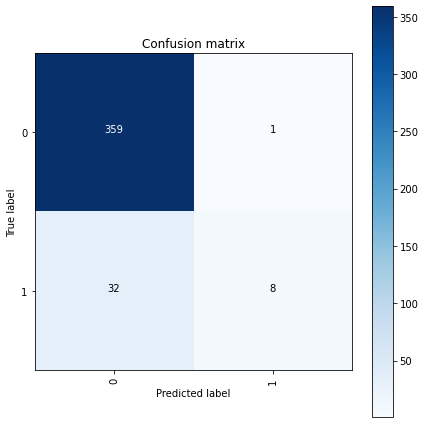

In [56]:
#ALEX_NET
plot_confusion_Matrix(val_classif_preds_alex,val_classif_gts_alex)

## Load Models Weights 

In [25]:
'''
vgg_model.load_state_dict(torch.load('/kaggle/working/best_AUC_weights_VGG.pth'))
with open('/kaggle/working/best_AUC_classifier_VGG.pkl', 'rb') as clf_file:
    clf = pickle.load(clf_file)
'''

"\nvgg_model.load_state_dict(torch.load('/kaggle/working/best_AUC_weights_VGG.pth'))\nwith open('/kaggle/working/best_AUC_classifier_VGG.pkl', 'rb') as clf_file:\n    clf = pickle.load(clf_file)\n"

In [57]:
alex_model.load_state_dict(torch.load('/kaggle/working/best_AUC_weights_alex.pth'))
with open('/kaggle/working/best_AUC_classifier_alex.pkl', 'rb') as clf_file:
    clf = pickle.load(clf_file)

## Predictions on test set

In [58]:
nb_test_batches = len(test_loader)

def test_probabilities(model) :
    model.eval()
    test_classif_pred = []
    with torch.no_grad():
        test_data = iter(test_loader)
        for k in range(nb_test_batches):
            # Loads data
            imgs = test_data.next()
            imgs = imgs.to(device)

            # Forward pass
            logits = model(imgs)
            _, preds = torch.max(logits, 1)

            output_ = F.softmax(logits, dim = 1)
            # Std out
            print('Test iter {}/{}'.format(k+1, nb_test_batches) + ' '*50, 
                  end='\r')

            # Compute and store probability
            test_classif_pred += logits.tolist()
            #running_loss += loss.item() * inputs.size(0)


        # Glaucoma predictions
        test_classif_pred = np.array(test_classif_pred)[:,1].reshape(-1,1)
        test_classif_preds = clf.predict_proba(test_classif_pred)[:,1]
    return test_classif_preds

# Prepare and save .csv file
def create_submission_csv(prediction, submission_filename='/kaggle/working/submission.csv'):
    """Create a sumbission file in the appropriate format for evaluation.

    :param
    prediction: list of predictions (ex: [0.12720, 0.89289, ..., 0.29829])
    """
    
    with open(submission_filename, mode='w') as csv_file:
        fieldnames = ['Id', 'Predicted']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()

        for i, p in enumerate(prediction):
            writer.writerow({'Id': "T{:04d}".format(i+1), 'Predicted': '{:f}'.format(p)})

test_classif_preds = test_probabilities(alex_model) #vgg_model for vgg_model
create_submission_csv(test_classif_preds)

# The submission.csv file is under /kaggle/working/submission.csv.
# If you want to submit it, you should download it before closing the current kernel.

# 4. Conclusion 
Thus through this project, we learnt how to create a model to classify image datasets and do its segmentation. For the scenario of classifying Glaucoma, we first preprocessed the dataset by upsampling and data augmentation methods and then fed the processed dataset through convolutional neural networks. By comparing VGG, Unet and Alexnet we found that the ALexnet model is performing better on the provided image dataset. The hyperparameters were tuned to avoid overfitting issues as well as enhanced the Test AUC of the model. If we would have more time to experiment, we would probably have experimented with the Dense Net model.
